# Palm 3 : Random Forest & Time Series modeling  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import math as math
import plotly.graph_objects as go

import time
import random
import seaborn as sns


import numpy as np
from os import path
from PIL import Image

from datetime import datetime
from dateutil import relativedelta
import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from io import StringIO

pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

In [2]:
# My Custom color and font scheme - to be used across all graphs 
my_title_col = 'darkslategray'
my_label_col = 'darkslategray'
my_graph_col = 'darkcyan'
my_title_font = 24
my_label_font = 20
my_ticks_font = 18
sns.color_palette("YlOrBr");

#### Define Functions 

In [3]:
# Functions 

def age_in_months(birth_date):
    difference = relativedelta.relativedelta(datetime.datetime.today(), birth_date)
    months = difference.years * 12 + difference.months
    return months

def age_in_years(birth_date):
    difference = relativedelta.relativedelta(datetime.datetime.today(), birth_date)
    years = difference.years
    return years

def age_from_to(from_date, to_date):
    difference = relativedelta.relativedelta(to_date, from_date)
    months = difference.years * 12 + difference.months
    return months



##### Build Scores function

In [4]:
# Function to catupre evalting metrics from different models
scores_df = pd.DataFrame
scores_df = pd.DataFrame(columns=['Model Type','Dataset','Metric','Score'],index=None)

def scores(scores_df,model,dataset,metric,score):
    scores_df = scores_df.append({'Model Type':model,
                'Dataset': dataset,
                'Metric': metric,
                'Score':score},
                ignore_index=True)
    return scores_df

In [5]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

### Decision Tree - Random Forest 

#### Scenerio - 8
- use lag of rain data with 6,12,24,26 months by adding and shifting rain_6,rain_12,rain_24 & rain_26 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers( crop greater than 127 tonnes per month) from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 
- not removing observations with zero crop

In [6]:
#load final fused dataset
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")


df = pd.get_dummies(df, columns=['blk'],drop_first=False) # create one hot-encoded blocks
df['month'] = df['date'].dt.month # adding new feature month
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months

df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

# rain data 
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi['rain_6'] = dfi['rain'].shift(6) # creating new feature with shift by 6 months
dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 24 months
dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift by 26 months
dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.
dfi.dropna(inplace=True) # drop first 26 rows with null rain_26 column


# Train & Val : 1-apr-2011 to 31-Dec-2019
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019
# remove outliers beyond 75 percent from train_val dataset
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 127].index,inplace=True)

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

#remove rows with zero crop
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] == 0].index,inplace=True)
dfi_m_test.drop(dfi_m_test[dfi_m_test['crop'] == 0].index,inplace=True)

# drop target variable from test dataset
dfi_m_test.drop('crop',axis=1,inplace=True)

#####################################################################################
# assign predictors and target variables
X = dfi_m_train.drop(['crop'],axis=1)
y = dfi_m_train['crop']

# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.15,shuffle=False)

# scaling predictors in train-val and test datasets
#ss = StandardScaler()
#ss.fit(X_train)
#X_train_scaled = ss.transform(X_train) 
#X_val_scaled = ss.transform(X_val) 
#test_scaled = ss.transform(dfi_m_test) # dataset for final test.

#rf = RandomForestClassifier(n_estimators=100)
rf = RandomForestRegressor(n_estimators=100, max_depth=10)

rf.fit(X_train,y_train)
y_preds = rf.predict(X_val)

scores_df = scores(scores_df,'Random Forest rf_S8','Train','R2',f'{round(rf.score(X_train,y_train),4)}')
scores_df = scores(scores_df,'Random Forest rf_S8','Val','R2',f'{round(rf.score(X_val,y_val),4)}')
#scores_df = scores(scores_df,'Random Forest rf_S8','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val)-1)/(len(X_val)-len(X_val[0])-1))),4)}')
scores_df = scores(scores_df,'Random Forest rf_S8','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, rf.predict(X_train))),2)}')
scores_df = scores(scores_df,'Random Forest rf_S8','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, rf.predict(X_val))),2)}')
scores_df = scores(scores_df,'Random Forest rf_S8','train','CVal_5',f'{round(cross_val_score(rf, X_train, y_train, cv=5).mean(),4)}')
scores_df.tail(5)

,Model Type,Dataset,Metric,Score
0,Random Forest rf_S8,Train,R2,0.1544
1,Random Forest rf_S8,Val,R2,0.072
2,Random Forest rf_S8,train,RMSE,19.68
3,Random Forest rf_S8,Val,RMSE,17.15
4,Random Forest rf_S8,train,CVal_5,0.0501


#### Scenerio - 8 Evaluate

In [7]:
# Calculate the absolute errors
errors = abs(y_preds - y_val)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_val)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 14.01 degrees.
Accuracy: 35.02 %.


In [8]:
display(y_val[0:2])
display(y_preds[0:2])

13948    49.66056
13949    44.46350
Name: crop, dtype: float64

array([42.01578405, 42.01578405])

#### Scenerio - 8 Feature Importance

In [9]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: blk_J03B             Importance: 0.12
Variable: blk_ZC01B            Importance: 0.12
Variable: blk_F07B             Importance: 0.11
Variable: blk_ZM102            Importance: 0.11
Variable: blk_E07B             Importance: 0.1
Variable: blk_E08B             Importance: 0.1
Variable: blk_B06              Importance: 0.07
Variable: blk_H106             Importance: 0.07
Variable: blk_K04B             Importance: 0.04
Variable: blk_I09              Importance: 0.03
Variable: blk_D07              Importance: 0.02
Variable: blk_J05B             Importance: 0.02
Variable: blk_J05C             Importance: 0.02
Variable: blk_D08              Importance: 0.01
Variable: blk_H02              Importance: 0.01
Variable: blk_J09              Importance: 0.01
Variable: blk_A01              Importance: 0.0
Variable: blk_A02              Importance: 0.0
Variable: blk_A03              Importance: 0.0
Variable: blk_A04              Importance: 0.0
Variable: blk_A05              Importance: 0.0

#### Scenerio - 10

- use lag of rain data with 6,12 months by adding and shifting rain_6,rain_12 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers( crop greater than 127 tonnes per month) from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 
- not removing observations with zero crop
- Use area, no of palms, age, class proportion
- compute age as of the month of the each crop data observation
- keeping observations with zero crop
- n_estimator = 100 max_depth = 8

In [37]:
#load final fused dataset
blocks = pd.read_csv("../data/blocks.csv")
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")

# merge with blocks to get block's static features
df = pd.merge(df, blocks,
                how='left', 
                left_on = 'blk', 
                right_on = 'blk', 
                copy=False)


df['mth_of_plant'] = df['mth_of_plant'].apply(lambda x: str(x))
df['mth_of_plant'] = pd.to_datetime(df['mth_of_plant'],yearfirst=True,format="%Y/%m/%d")
    
# compute age as of the month year and month of the crop.
for i in df.index:
    difference = relativedelta.relativedelta(pd.to_datetime(df.loc[i]['date']), 
                                             pd.to_datetime(df.loc[i]['mth_of_plant']))
    months = difference.years * 12 + difference.months
    df.at[i,'age'] = months

#Drop features not required for modeling 
df.drop(['plant_mat','mth_of_plant','syp1_ha','syp2_ha','syp3_ha', 'syp4_ha','syp5_ha','density'],
        axis=1,inplace=True)

# create one hot-encoded blocks
df['blk_eval'] = df['blk'] # keep copy of block name for evaluation of the model
df = pd.get_dummies(df, columns=['blk'],drop_first=False) 

# add new feature month
df['month'] = df['date'].dt.month 
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months

df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

# rain data 
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi['rain_1'] = dfi['rain'].shift(1) # creating new feature with shift 
dfi['rain_2'] = dfi['rain'].shift(2) # creating new feature with shift 
dfi['rain_3'] = dfi['rain'].shift(3) # creating new feature with shift 
#dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift
dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.
dfi.dropna(inplace=True) # drop rows with NaN due to shifting of rain
dfi['date'] = dfi.index 


# Train & Val : 1-apr-2011 to 31-Dec-2019
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

# remove outliers from train_val dataset
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 120].index,inplace=True)

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

#remove rows with zero crop
#dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] == 0].index,inplace=True)
#dfi_m_test.drop(dfi_m_test[dfi_m_test['crop'] == 0].index,inplace=True)


# assign predictors and target variables
y = dfi_m_train['crop']

# split train data into train and validation datasets
df_train,df_val,y_train,y_val = train_test_split(dfi_m_train,y,test_size=0.15,shuffle=False)

X_train = df_train.drop(['crop','date','blk_eval'],axis=1)
X_val = df_val.drop(['crop','date','blk_eval'],axis=1)

# remove label data - crop and other features needed for evaluation from final test dataset
dfi_m_test.drop(['crop','date','blk_eval'],axis=1,inplace=True)


# scaling predictors in train-val and test datasets
#ss = StandardScaler()
#ss.fit(X_train)
#X_train_scaled = ss.transform(X_train) 
#X_val_scaled = ss.transform(X_val) 
#test_scaled = ss.transform(dfi_m_test) # dataset for final test.

#rf = RandomForestClassifier(n_estimators=100)
rf = RandomForestRegressor(n_estimators=100,max_depth=8)

rf.fit(X_train,y_train)
y_preds = rf.predict(X_val)

scores_df = scores(scores_df,'Random Forest  rf_S10','Train','R2',f'{round(rf.score(X_train,y_train),4)}')
scores_df = scores(scores_df,'Random Forest rf_S10','Val','R2',f'{round(rf.score(X_val,y_val),4)}')
#scores_df = scores(scores_df,'Random Forest rf_S10','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val)-1)/(len(X_val)-len(X_val[0])-1))),4)}')
scores_df = scores(scores_df,'Random Forest  rf_S10','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, rf.predict(X_train))),2)}')
scores_df = scores(scores_df,'Random Forest  rf_S10','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, rf.predict(X_val))),2)}')
scores_df = scores(scores_df,'Random Forest rf_S10','train','CVal_5',f'{round(cross_val_score(rf, X_train, y_train, cv=5).mean(),4)}')
scores_df.tail(5)


,Model Type,Dataset,Metric,Score
10,Random Forest rf_S10,Train,R2,0.691
11,Random Forest rf_S10,Val,R2,0.4656
12,Random Forest rf_S10,train,RMSE,12.26
13,Random Forest rf_S10,Val,RMSE,13.29
14,Random Forest rf_S10,train,CVal_5,0.5577


In [11]:
scores_df.tail(5)

,Model Type,Dataset,Metric,Score
5,Random Forest rf_S10,Train,R2,0.6915
6,Random Forest rf_S10,Val,R2,0.4662
7,Random Forest rf_S10,train,RMSE,12.25
8,Random Forest rf_S10,Val,RMSE,13.28
9,Random Forest rf_S10,train,CVal_5,0.5576


#### Scenerio - 10 Evaluate

In [12]:
# residual of LR model on validation dataset
print(len(y_val),len(y_preds),len(df_val))
resd = y_val - y_preds
df_eval = df_val.copy()
df_eval['crop_preds'] = y_preds
df_eval['variance'] = (df_eval['crop'] - df_eval['crop_preds'])
df_eval[['date','blk_eval','crop','crop_preds','variance']].head()

2369 2369 2369


,date,blk_eval,crop,crop_preds,variance
13423,2018-11-30,ZD102,35.20718,42.758407,-7.551227
13424,2018-11-30,E105,59.30932,62.456482,-3.147162
13425,2018-11-30,G105,51.90107,55.556174,-3.655104
13426,2018-11-30,G10,41.30265,44.802960,-3.500310
13427,2018-11-30,K09,17.60082,18.825775,-1.224955


In [13]:
graph = df_eval.groupby(['date'])[['crop','crop_preds']].sum()

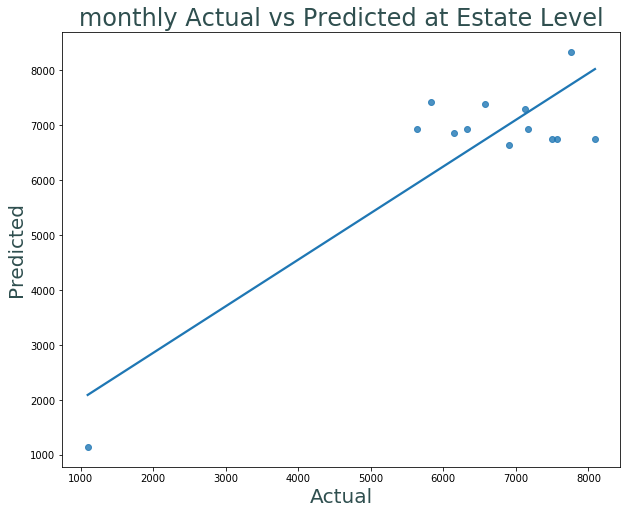

In [14]:
# Plot monthly estate level actaul vs predicted
xf=graph['crop']
yf=graph['crop_preds']
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'monthly Actual vs Predicted at Estate Level'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

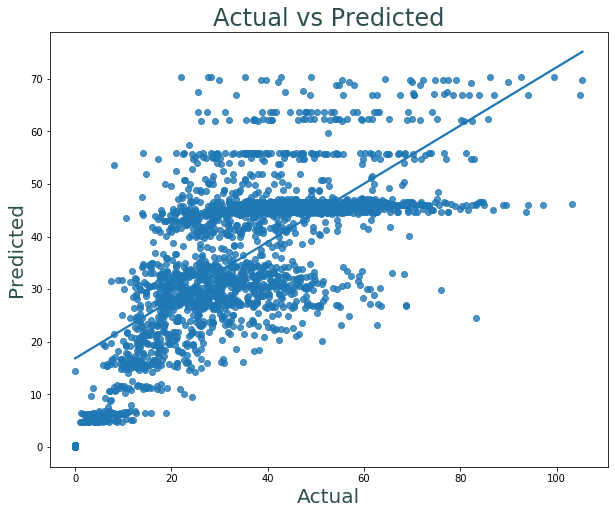

In [38]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 10 Feature Importance

In [15]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: blk_A01              Importance: 0.6
Variable: blk_A08              Importance: 0.13
Variable: blk_A02              Importance: 0.07
Variable: blk_E102             Importance: 0.05
Variable: blk_E11              Importance: 0.05
Variable: blk_E100             Importance: 0.02
Variable: blk_E12              Importance: 0.02
Variable: blk_A06              Importance: 0.01
Variable: blk_A03              Importance: 0.0
Variable: blk_A04              Importance: 0.0
Variable: blk_A05              Importance: 0.0
Variable: blk_A07              Importance: 0.0
Variable: blk_A09              Importance: 0.0
Variable: blk_A10              Importance: 0.0
Variable: blk_A100             Importance: 0.0
Variable: blk_A101             Importance: 0.0
Variable: blk_A102             Importance: 0.0
Variable: blk_A11              Importance: 0.0
Variable: blk_A12              Importance: 0.0
Variable: blk_A13              Importance: 0.0
Variable: blk_A14              Importance: 0.0
Variab

In [16]:
scores_df['Score'] = scores_df['Score'].astype(float)
scores_df[scores_df['Metric'] == 'RMSE'].sort_values(by='Score')

,Model Type,Dataset,Metric,Score
7,Random Forest rf_S10,train,RMSE,12.25
8,Random Forest rf_S10,Val,RMSE,13.28
3,Random Forest rf_S8,Val,RMSE,17.15
2,Random Forest rf_S8,train,RMSE,19.68


## Time Series

In [17]:
# load data from final fused dataset 
df = pd.read_csv('../data/final_fused.csv')
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")



In [18]:
#load final fused at daily level dataset
df = pd.read_csv("../data/final_fused.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")
df = df.sort_values('date')

dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[dfi.index < '2020-01-01'] # train & val dataset
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi_mean_3 = dfi[['crop']].resample('M').mean().rolling(window=3, center=False).mean() # resampling for monthly totals

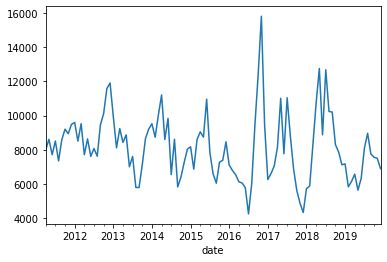

In [19]:
dfi['crop'].plot()

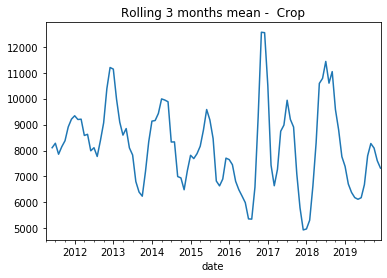

In [20]:
dfi_mean_3['crop'].plot(title='Rolling 3 months mean -  Crop')

In [21]:
# Run ADF test on original (non-differenced!) data.
adfuller(dfi['crop'])

(-5.758958368585296,
 5.731631535087724e-07,
 2,
 102,
 {'1%': -3.4961490537199116,
  '5%': -2.8903209639580556,
  '10%': -2.5821223452518263},
 1598.6697780178315)

In [22]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(dfi['crop']))

Test Statistic   -5.758958e+00
p-value           5.731632e-07
dtype: float64

**P-value is much higher than alpha of 0.01, so as per ADF test crop data is NOT stationary.**

In [23]:
# Create crop_diff1 and crop_diff2
# columns in df.
dfi['crop_diff1'] = dfi['crop'].diff(1)
dfi['crop_diff2'] = dfi['crop'].diff(1).diff(1)

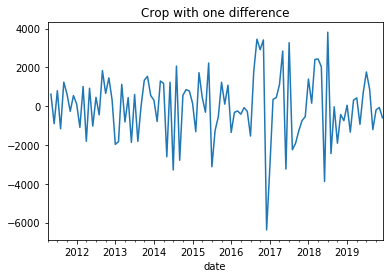

In [24]:
dfi['crop_diff1'].plot(title='Crop with one difference');

In [25]:
# Run ADF test on original (one-differenced!) data.
adfuller(dfi['crop_diff1'].dropna())

(-5.270102671911272,
 6.312969253309583e-06,
 13,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 1594.6989106173246)

In [26]:
# Run ADF test on original (one-differenced!) data.
interpret_dftest(adfuller(dfi['crop_diff1'].dropna()))

Test Statistic   -5.270103
p-value           0.000006
dtype: float64

**One differenced crop data is stationary since p-value is much smaller than 0.01.**

#### ARIMA

There are three hyperparameters we need to get values for when fitting an ARIMA model.
1. Determine a value of $d$ using the Augmented Dickey-Fuller test.
2. Then, determine values of $p$ and $q$ through GridSearching.

An $ARIMA(p, d, q)$ model is specified by:
- how many differences $d$ we need to calculate in order to achieve stationarity.
- how many lags $p$ we regress $Y_t^{(d)}$ on.
- how many errors $q$ we regress $Y_t^{(d)}$ on.

##### Scenerio - 1

In [27]:
# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020


dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi_m_train = dfi[dfi.index < '2020-01-01'].copy() # train & val dataset
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test data
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # keeping data only until 31-may-2020

dfi_m_test.drop('crop',axis=1,inplace=True) # dropping target variable from test dataset

# Removing date as index for modeling
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

In [28]:
# create one difference 
dfi_m_train['crop_diff1'] = dfi_m_train['crop'].diff(1)

In [29]:
y_train, y_test = train_test_split(dfi_m_train['crop'],
                                   test_size = 0.1,
                                   shuffle = False) # Shuffle = False is IMPORTANT!

In [30]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 0, q) model.
            print(f'Attempting to fit ARIMA({p},1,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
                          order = (p,1,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,1,0)
The AIC for ARIMA(0,1,0) is: 1658.9136654492104
Attempting to fit ARIMA(0,1,1)
The AIC for ARIMA(0,1,1) is: 1658.410717362505
Attempting to fit ARIMA(0,1,2)
The AIC for ARIMA(0,1,2) is: 1659.818750588742
Attempting to fit ARIMA(0,1,3)
The AIC for ARIMA(0,1,3) is: 1639.5884618909788
Attempting to fit ARIMA(0,1,4)
The AIC for ARIMA(0,1,4) is: 1636.9256762380246
Attempting to fit ARIMA(1,1,0)
The AIC for ARIMA(1,1,0) is: 1658.0117936361219
Attempting to fit ARIMA(1,1,1)
The AIC for ARIMA(1,1,1) is: 1657.109452250324
Attempting to fit ARIMA(1,1,2)
The AIC for ARIMA(1,1,2) is: 1658.9847972070645
Attempting to fit ARIMA(1,1,3)
The AIC for ARIMA(1,1,3) is: 1638.2889881534447
Attempting to fit ARIMA(1,1,4)
The AIC for ARIMA(1,1,4) is: 1638.7442095569188
Attempting to fit ARIMA(2,1,0)
The AIC for ARIMA(2,1,0) is: 1658.9661436935087
Attempting to fit ARIMA(2,1,1)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(2,1,1) is: 1658.9852687560615
Attempting to fit ARIMA(2,1,2)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(2,1,2) is: 1648.84718940983
Attempting to fit ARIMA(2,1,3)
The AIC for ARIMA(2,1,3) is: 1638.6836118698939
Attempting to fit ARIMA(2,1,4)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/pyth

The AIC for ARIMA(2,1,4) is: 1642.2904408595946
Attempting to fit ARIMA(3,1,0)
The AIC for ARIMA(3,1,0) is: 1656.6560857404847
Attempting to fit ARIMA(3,1,1)
The AIC for ARIMA(3,1,1) is: 1637.420097344031
Attempting to fit ARIMA(3,1,2)
Attempting to fit ARIMA(3,1,3)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(3,1,3) is: 1640.2975380861005
Attempting to fit ARIMA(3,1,4)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(3,1,4) is: 1642.0472658045685
Attempting to fit ARIMA(4,1,0)
The AIC for ARIMA(4,1,0) is: 1652.9836933438228
Attempting to fit ARIMA(4,1,1)
The AIC for ARIMA(4,1,1) is: 1638.9905835301313
Attempting to fit ARIMA(4,1,2)
The AIC for ARIMA(4,1,2) is: 1640.969087974502
Attempting to fit ARIMA(4,1,3)
The AIC for ARIMA(4,1,3) is: 1641.2833212785529
Attempting to fit ARIMA(4,1,4)
The AIC for ARIMA(4,1,4) is: 1642.2847321860138


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,4).
This model has an AIC of 1636.9256762380246.


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [31]:
y_train

0      7994.20059
1      8614.03416
2      7714.13505
3      8511.76212
4      7345.95696
5      8584.37312
6      9202.49179
7      8938.96193
8      9483.41076
9      9597.96322
10     8505.89268
11     9521.02500
12     7715.13953
13     8637.70697
14     7614.38662
15     8071.89968
16     7626.28897
17     9459.09261
18    10119.86002
19    11577.34168
20    11903.82566
21     9935.53601
22     8112.98844
23     9239.38802
24     8428.62868
25     8870.81157
26     7004.82251
27     7607.16302
28     5797.52756
29     5793.26759
30     7127.53884
31     8664.04662
32     9213.40346
33     9521.40111
34     8733.93593
35    10030.40355
36    11204.83669
37     8600.27903
38     9834.51460
39     6547.96966
40     8613.97564
41     5827.54804
42     6391.22105
43     7245.28513
44     8026.17391
45     8177.73870
46     6863.54975
47     8589.58879
48     9046.49832
49     8735.33228
50    10959.25347
51     7839.50857
52     6589.02555
53     6045.12218
54     7276.33282
55     738

In [32]:
y_test.index[0]

94

In [33]:
y_test

94     5835.13835
95     6147.69893
96     6574.74291
97     5639.26342
98     6327.53989
99     8090.56160
100    8962.29218
101    7756.53979
102    7564.17590
103    7499.38867
104    6898.83800
Name: crop, dtype: float64

In [34]:
y_test.index[0]

94

In [35]:
y_test.index[-1]

104

In [36]:
preds

NameError: name 'preds' is not defined

In [ ]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (0,1,4))

# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced Global Mean Temperature with ARIMA(0, 1, 4) Predictions', fontsize=16)
plt.show();

In [ ]:
preds